# Testing the code using Reduced Order Quadrature on simulated signal

This notebook provides tests of the `lalapps_pulsar_parameter_estimation_nested` code running using a Reduced Order Quadrature (ROQ) to produce an approximation of the likelihood. Here I run the code over a small range in frequency and frequency derivative, but with a signal that has been re-heterodyned to offset the frequency.

In [1]:
# import required modules

%matplotlib inline

from __future__ import print_function, division

import numpy as np
from scipy.signal import fftconvolve
import subprocess as sp
import os
import sys
import gzip
from time import time
import h5py

from scotchcorner import scotchcorner

# these modules require lalapps
from lalapps.pulsarpputils import *

# some matplotlib configurations
mplparams = { \
      'backend': 'Agg',
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': True, # add a grid
      'grid.linewidth': 0.5,
      'font.family': 'sans-serif',
      'font.sans-serif': 'Avant Garde, Helvetica, Computer Modern Sans serif',
      'font.size': 15 }

In [2]:
# set up the run directories
rundir = '.'
if not os.path.isdir(rundir): # make the directory
    os.makedirs(rundir)

detector = 'H1'        # the detector to use
psrname = 'J0000+0000' # a fake pulsar name

# set the output directory
outdir = os.path.join(rundir, 'output')
if not os.path.isdir(outdir):
    os.makedirs(outdir)

# fake heterodyned data directory (for the lalapps_pulsar_parameter_estimation code
# this must be dataDET, where DET is e.g. H1)
datadir = os.path.join(rundir, 'data'+detector)
if not os.path.isdir(datadir): # make the directory
    os.makedirs(datadir)

# set the executables (this assumes that you are using virtual environments with virtualenvwrapper.sh and
# have a WORKON_HOME environment variable set, but you can change the path as required)
virenv = 'lalapps_knope_O1' # name of your virtual environment
execpath = os.path.join(os.environ['WORKON_HOME'], virenv)
execpath = os.path.join(execpath, 'bin')

ppenexec = os.path.join(execpath, 'lalapps_pulsar_parameter_estimation_nested')
n2pexec = os.path.join(execpath, 'lalapps_nest2pos') # script to convert nested samples to posterior samples
hetexec = os.path.join(execpath, 'lalapps_heterodyne_pulsar')

## Running the codes

The code is run on random Gaussian noise with zero mean and a given standard deviation. The prior file adds frequency `F0` and first frequency derivative `F1` parameters and assumes Gaussian prior distributions on these.

I output a comparison plot between the posteriors produced with and without the ROQ. I compare the upper limits, evidences and maximum likelihoods produced by each method. I also compare the run times for each implementation of the code.

In [3]:
# set up some general inputs

# create a pulsar parameter (TEMPO-stype .par file) file format string
pardat = """PSRJ J0000+0000
RAJ {} {}
DECJ {}
F0 {} {}
F1 {} {}
PEPOCH 56789.0
EPHEM DE405
UNITS TDB
"""

# some defaults for the data generation
sigma = 1.0e-22        # set data standard deviation
dt = 60                # number of seconds between data points
gpsstart = 1125969920  # GPS start time of data (over a year after the pulsar period epoch)
duration = 86400*2     # duration of data (seconds) - 2 days
gpstimes = np.arange(gpsstart, gpsstart+duration, dt) # time stamps
dlen = len(gpstimes)   # length of data

# get an estimate of the 95% credible upper limit to be expected
ulest = 10.8*np.sqrt(sigma**2/dlen)

# create the signal
pardict = {}
pardict['h0'] = sigma
pardict['psi'] = np.random.rand()*np.pi/2. # get random polarisation angle
pardict['cosiota'] = 0.2
pardict['phi0'] = 1.0

# create a random sky position from a uniform distribution on the sky
pardict['ra'] = 2.*np.pi*np.random.rand()
pardict['dec'] = np.arccos(-1.+2.*np.random.rand()) - np.pi/2.

# set the required SNR of the signal
snr = 10.

# generate signal
tssig, sig = heterodyned_pulsar_signal(gpsstart, duration, dt, detector, pardict)

# calculate SNR
snropt = get_optimal_snr(sig[0], sigma)

# scale signal to required SNR
sig[0] = sig[0]*(snr/snropt)

h0true = sigma*(snr/snropt) # the new h0 value

# upper range of prior
h0max = h0true + ulest*6.

# create the prior file for the lalapps_pulsar_parameter_estimation_nested code
# the F0 and F1 parameters have Gaussian prior distributions
f0mu = 123.4567890
f0sigma = 5e-6
f0offset = 3e-6
f1mu = -2e-11
f1sigma = 4e-12
f1offset = 1e-12
rasigma = 1e-3
raoffset = 5e-4

priorfile = os.path.join(rundir, 'pulsar.prior')
priordat = """H0 uniform 0 {}
PHI0 uniform 0 {}
PSI uniform 0 {}
COSIOTA uniform -1 1
F0 gaussian {:.7f} {:.1e}
F1 gaussian {:.7e} {:.5e}
RA gaussian {:.12f} {:.12f}
"""
fp = open(priorfile, 'w')
# set the h0 upper range to be 6 times the expected upper limit 
fp.write(priordat.format(ulest*15., np.pi, np.pi/2., f0mu, f0sigma, f1mu, f1sigma, pardict['ra'], rasigma))
fp.close()

# lalapps_pulsar_parameter_estimation_nested run parameters
Nlive = '256' # number of nested sample live points

# ROQ setup
ntraining = '2500'     # the number of training models to form the reduced basis
roqtolerance = '5e-12' # the maximum allowed residuals between the training set and reduced basis
roqfile = os.path.join(datadir, 'roq.bin') # a file to output the ROQ intepolants and nodes

/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O1/bin/lalapps_heterodyne_pulsar -i H1 -p J0000+0000 -z 4 -f ./pulsar.par -g ./pulsar_offset.par -e /opt/lscsoft/share/lalpulsar/earth00-19-DE405.dat.gz -S /opt/lscsoft/share/lalpulsar/sun00-19-DE405.dat.gz -t /opt/lscsoft/share/lalpulsar/tdb_2000-2019.dat.gz -s 1 -r 1 -d ./dataH1/finehet_J0000+0000_H1 -o ./dataH1/finehet_offset_J0000+0000_H1 -l ./dataH1/segments.txt


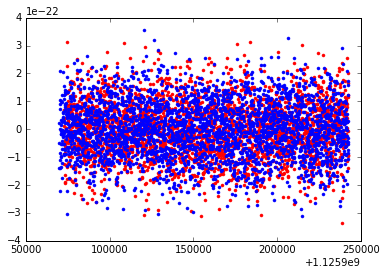

In [4]:
# create data
data = sigma*np.random.randn(dlen, 2)

# add signal to data
data[:,0] = data[:,0] + sig[0].real
data[:,1] = data[:,1] + sig[0].imag

# append times and data together
tad = np.vstack((gpstimes, data.T)).T

# output fake data
datafile = os.path.join(datadir, 'finehet_'+psrname+'_'+detector)
np.savetxt(datafile, tad, fmt='%.6f %.7e %.7e', delimiter='\t')
    
# covert RA and DEC to dd:mm:ss.s format
rah, ram, ras = rad_to_hms(pardict['ra'])
decd, decm, decs = rad_to_dms(pardict['dec'])

# output .par
parfile = os.path.join(rundir, 'pulsar.par')
fp = open(parfile, 'w')
fp.write(pardat.format(coord_to_string(rah, ram, ras), "", coord_to_string(decd, decm, decs), f0mu, "", f1mu, ""))
fp.close()

# create offset heterodyne par file
parfileoff = os.path.join(rundir, 'pulsar_offset.par')
fp = open(parfileoff, 'w')
rah, ram, ras = rad_to_hms(pardict['ra']+raoffset)
fp.write(pardat.format(coord_to_string(rah, ram, ras), "1 %.12f" % (rasigma*(180./np.pi)*(60.*60.)), coord_to_string(decd, decm, decs), f0mu+f0offset, "1 %.12f" % f0sigma,
                       f1mu+f1offset, "1 %.12e" % f1sigma))
fp.close()
segfile = os.path.join(datadir, 'segments.txt')
fp = open(segfile, 'w')
fp.write('%d %d\n' % (int(gpsstart), int(gpsstart+duration)))
fp.close()

datafileoff = os.path.join(datadir, 'finehet_offset_'+psrname+'_'+detector)

# run lalapps_heterodyne_pulsar to re-heterodyne the signal with an offset frequency
codecall = ' '.join([hetexec, '-i', detector, '-p', psrname, '-z', '4', '-f', parfile, '-g', parfileoff,
                    '-e', '/opt/lscsoft/share/lalpulsar/earth00-19-DE405.dat.gz',
                    '-S', '/opt/lscsoft/share/lalpulsar/sun00-19-DE405.dat.gz',
                    '-t', '/opt/lscsoft/share/lalpulsar/tdb_2000-2019.dat.gz',
                    '-s', '1', '-r', '1', '-d', datafile, '-o', datafileoff, '-l', segfile])
print(codecall)
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

hetdata = np.loadtxt(datafileoff, comments='%')

from matplotlib import pyplot as pl
pl.plot(hetdata[:,0], hetdata[:,1], 'r.', np.arange(gpsstart, gpsstart+duration, dt), data[:,0], 'b.')

In [5]:
# run lalapps_pulsar_parameter_estimation using the ROQ (first run to generate the ROQ)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfileoff, '--prior-file', priorfile,
                     '--input-files', datafileoff, '--outfile', os.path.join(outdir, 'fake_nest_roq.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq', '--roq-tolerance',
                     roqtolerance, '--ntraining', ntraining, '--output-weights', roqfile, '--chunk-max', '1440'])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timegenerateroq = (t1-t0)

# run lalapps_pulsar_parameter_estimation using the ROQ (using pregenerated ROQ)
codecall = ' '.join([ppenexec, '--detectors', detector,
                     '--par-file', parfileoff, '--prior-file', priorfile,
                     '--input-files', datafileoff, '--outfile', os.path.join(outdir, 'fake_nest_roq.hdf'),
                     '--Nlive', Nlive, '--Nmcmcinitial', '0', '--roq', '--input-weights', roqfile,
                     '--chunk-max', '1440'])

t0 = time()
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()
t1 = time()
timeroq = (t1-t0)

Read columns ['COSIOTA', 'F0', 'F1', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'HVECTORY', 'C21', 'HVECTORX', 'PHI0VECTOR', 'PHI0SCALAR', 'PMDEC', 'PEPOCH', 'PMRA', 'HPLUS', 'I31', 'PHI22', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0TENSOR', 'HCROSS', 'COSTHETA', 'DEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'THETA', 'F1_FIXED', 'PSIVECTOR', 'F0_FIXED', 'PSISCALAR', 'LAMBDA']


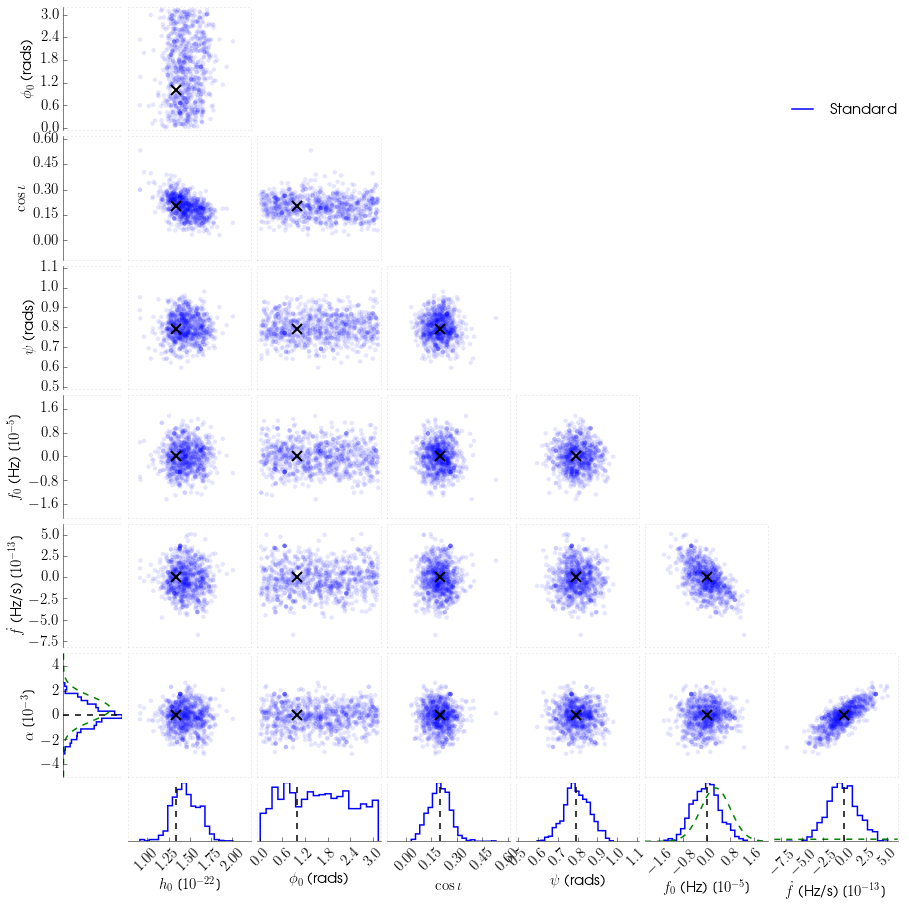

In [6]:
# nested samples need to be converted to posterior samples with lalapps_nest2pos
if os.path.isfile(os.path.join(outdir, 'fake_post_roq.hdf')):
    os.remove(os.path.join(outdir, 'fake_post_roq.hdf'))
codecall = ' '.join([n2pexec, '-p', os.path.join(outdir, 'fake_post_roq.hdf'),
                     os.path.join(outdir, 'fake_nest_roq.hdf')])
p = sp.Popen(codecall, stdout=sp.PIPE, stderr=sp.PIPE, shell=True)
out, err = p.communicate()

# get h0 upper limit
postroq, evsigroq, evnoiseroq = pulsar_nest_to_posterior(os.path.join(outdir, 'fake_post_roq.hdf'))
h0ulroq = upper_limit_greedy(postroq['h0'].samples, upperlimit=0.95)
    
h0ulnestedroq = (h0ulroq)
evratnestedroq = (evsigroq-evnoiseroq)

# get the maximum likelihood
evfileroq = h5py.File(os.path.join(outdir, 'fake_nest_roq.hdf'), 'r')
maxlikeroq = evfileroq['lalinference']['lalinference_nest'].attrs['log_max_likelihood']
evfileroq.close()

params = ['h0', 'phi0', 'cosiota', 'psi', 'f0', 'f1', 'ra']

# lalapps_pulsar_parameter_estimation_nested posterior samples
postppenroq = np.zeros((len(postroq['h0'].samples), len(params)))
for i, p in enumerate(params):
    postppenroq[:,i] = postroq[p].samples[:,0]

histops = {'histtype': 'step', 'color': 'b', 'edgecolor': 'b', 'linewidth': 1.5, 'alpha': 1.0}
labels = ['$h_0$', '$\phi_0$ (rads)', '$\cos{\iota}$', '$\psi$ (rads)', '$f_0$ (Hz)', '$\dot{f}$ (Hz/s)', '$\\alpha$']
limits = [(0., None), (0., np.pi), (-1., 1.), (0., np.pi/2.),  (None, None), (None, None), (None, None)]
truths = [h0true, pardict['phi0'], pardict['cosiota'], pardict['psi'], 0., 0., 0.]

# subtract means from f0 and f1
postppenroq[:,params.index('f0')] = postppenroq[:,params.index('f0')] - f0mu
postppenroq[:,params.index('f1')] = postppenroq[:,params.index('f1')] - f1mu
postppenroq[:,params.index('ra')] = postppenroq[:,params.index('ra')] - pardict['ra']

# plot posteriors
sc = scotchcorner(postppenroq, bins=20, ratio=2, labels=labels, datatitle='Standard', showlims='both', hist_kwargs=histops,
                  showcontours=False, limits=limits, showpoints=True, scatter_kwargs={'alpha': 0.1}, truths=truths,
                  truths_kwargs={'color': 'k', 'markersize': 10, 'markeredgewidth': 2})

# add F0 prior distribution
from scipy.stats import norm
axf0 = sc.get_axis('$f_0$ (Hz)')
f0range = np.linspace(axf0.get_xlim()[0], axf0.get_xlim()[1], 100)
axf0.plot(f0range, norm.pdf(f0range, f0offset, f0sigma), 'g--', lw=1.5)

axra = sc.get_axis('$\\alpha$')
rarange = np.linspace(axra.get_ylim()[0], axra.get_ylim()[1], 100)
axra.plot(norm.pdf(rarange, raoffset, rasigma), rarange, 'g--', lw=1.5)

axf1 = sc.get_axis('$\dot{f}$ (Hz/s)')
f1range = np.linspace(axf1.get_xlim()[0], axf1.get_xlim()[1], 100)
axf1.plot(f1range, norm.pdf(f1range, f1offset, f1sigma), 'g--', lw=1.5)
